# ADT

In [2]:
import os
import sys

import pickle
import numpy as np
import glob

import warnings # ignore tensorflow warinings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from keras import backend as K
import soundfile as psf

sys.path.append('models')
from large_vocab_adt_dafx2018.transcribe import transcribe, PERC_VOICE_SET
import large_vocab_adt_dafx2018.model as model

# pip install pyrsistent==0.16.1

## Download Groove MIDI Dataset

In [3]:
# DOWNLOAD GROOVE MIDI DATASET
import requests, zipfile, io

groove_path = 'groove/'

# if dir exists and is empty, remove
if os.path.exists(groove_path) and os.listdir(groove_path)==0:
    os.removedirs(groove_path)

# if dir does not exist, download dataset
if not os.path.exists(groove_path):
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("./")

In [4]:
# files in dataset
import pandas as pd

# load info from dataset
magenta_ds = pd.read_csv('groove/info.csv')

# remove rows without wav file
magenta_ds = magenta_ds.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False) 

magenta_ds.head()

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test


## Compute ADT to 8 voices

Since the model outputs 14 voices, we need to reduce them to the 8 ones present in the magenta dataset. In the magenta dataset there's actually 9 but one has no correspondence with the ones that this model outputs, so I removed it

### Get model onsets function

In [11]:
def get_model_onsets(input_audio_file, model_num=303):
    
    models_path = 'models/large_vocab_adt_dafx2018/trained_models/'

    # load model
    model_definition_path = os.path.join(models_path,str(model_num)+'_s0_def.json')
    model_weights_path = os.path.join(models_path,str(model_num)+'_s0_weights.h5')
    model_configuration_id = model_num
    sample_audio_files = dict([(v, os.path.join('models/audio/', '{}.wav'.format(v))) for v in PERC_VOICE_SET])


    # compute model's onsets >> outputs 14 voices
    output = transcribe(model_definition_path,
                    model_weights_path,
                    input_audio_file,
                    model_configuration_id,
                    sample_audio_files,
                    peak_params=None,
                    output_sample_rate=44100)

    # save into out_14v
    out_14v = output['14v']['onset_activations']
    
    # reduce 14 voices to the 8 present in the magenta dataset
    length_in_samples = out_14v.shape[0]
    out_8v = np.zeros([length_in_samples,8])

    reduced_mapping = {
    0: [0],     # kick
    1: [1,2],   # snare + snare rim 
    2: [3],     # crash
    3: [4,12],  # ride + bell
    4: [5],     # open hh
    5: [6],     # closed hh
    6: [7,8],   # low+mid tom
    7: [9]      # high tom
    }


    eps = 0 # threshold ?

    for t in range(length_in_samples):
        t_roll = out_14v[t,:]
        t_roll[t_roll<eps] = 0
        for i in reduced_mapping.keys():
            out_8v[t,i] = np.max(t_roll[reduced_mapping[i]])
    
    return out_8v

## Extract onsets from midi file

### Get magenta onsets function

In [12]:
import pretty_midi

def get_magenta_onsets(input_midi_file):
    # read with prettyMIDI
    midi_data = pretty_midi.PrettyMIDI(input_midi_file)
        
    length_in_samples = int(midi_data.get_end_time()/0.01)

    # extract onsets from midi file with midi_data.get_onsets()
    onsets = midi_data.get_onsets()
    
    # get pretty_midi Notes objects in a list
    drums_notes = midi_data.instruments[0].notes[:]
    
    # initiate drum_onsets and instruments array
    drums_onsets = []
    drums_instrument = []
    
    # fill with info from prettymidi notes objects
    for note in drums_notes:
        drums_onsets.append(note.start)    # onsets list
        drums_instrument.append(note.pitch)   # instrument  
    
    # transform onsets to seconds
    drums_onsets = np.round(drums_onsets,2) # in seconds
    drums_onsets = np.round(drums_onsets/0.01,0) # in samples

    
    # magenta pitch to model pitch (map to 8 voices)
    magenta_mapping = { # [key, [pitches]]
        "kick":[0,[36]],
        "snare":[1,[38,40,37]],
        "crash":[2,[49,55,57,52]],
        "ride":[3,[51,59,53]],
        "open_hh":[4,[46,26]],
        "closed_hh":[5,[42,22,44]],
        "low_mid_tom":[6,[45,47]],
        "high_tom":[7,[48,50]]
        }
    
    # initiate magenta_transcription matrix with zeros
    magenta_transcription = np.zeros([length_in_samples,8])

    # fill magenta_transcription with onsets info
    for onset,inst in zip(drums_onsets,drums_instrument):
        onset = int(onset)
    
        # map pretty_midi pitch to magenta pitch value
        for magenta_inst in magenta_mapping.keys():
        
            if inst in magenta_mapping[magenta_inst][1]:
                magenta_transcription[onset][magenta_mapping[magenta_inst][0]] = 1
    
    return magenta_transcription
    

# Plot

In [13]:
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline

def plot_activations(X, start_s, stop_s, sample_interval, sr=44100, size=(15,5)):
    sample_interval = int(round(sample_interval * sr)) / float(sr)
    hop_length = int(sample_interval * sr)
    start_idx = int(start_s / sample_interval)
    stop_idx = int(stop_s / sample_interval)
    plt.figure(figsize=size)
        
    librosa.display.specshow(X[start_idx:stop_idx,:].T, 
                             sr=sr, 
                             hop_length=hop_length,
                             x_axis='time')
        
    labels = ['0 : Kick Drum', # 0
                  '1 : Snare', # 1 Snare + Snare Rim
                  '2 : Crash', # 2
                  '3 : Ride', # 3 Ride + Bell
                  '4 : Open Hi-Hat', # 4
                  '5 : Closed Hi-Hat', # 5
                  '6 : Low-Mid Tom', # 6 Low + Mid
                  '7 : High Tom'] # 7
     
    plt.yticks(np.arange(X.shape[1]) + 0.5, labels)
    
    # TODO change range in x

In [14]:
input_audio_file = 'groove/drummer1/session1/1_funk_80_beat_4-4.wav'
input_midi_file = input_audio_file.split('.')[-2] + '.mid'

magenta_transcription = get_magenta_onsets(input_midi_file)
out_8v = get_model_onsets(input_audio_file)

# Plot activations

Text(0.5,1,'magenta')

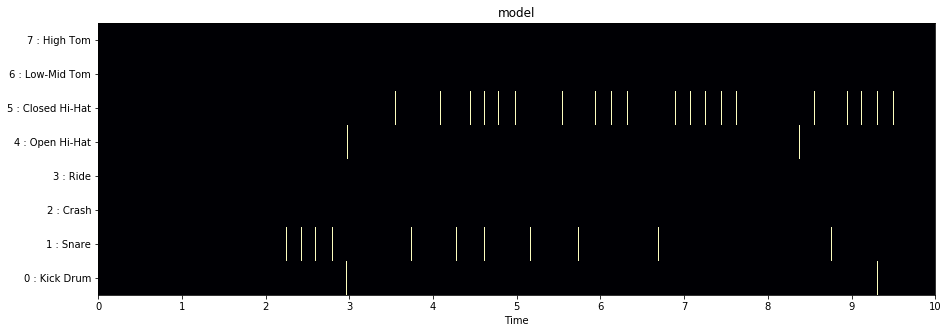

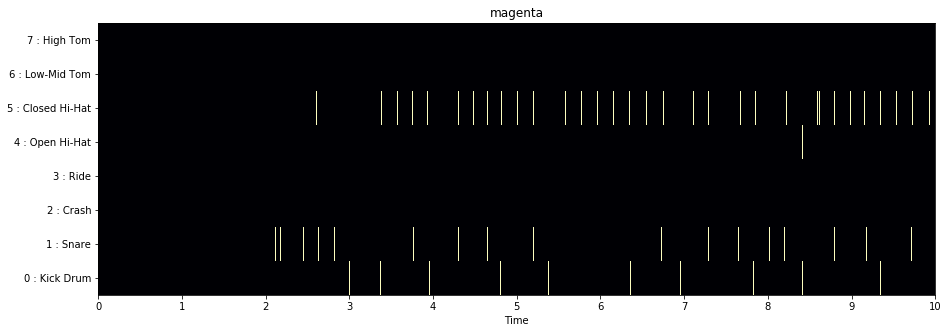

In [15]:
threshold = 0.5
out_8v_thres = np.array(out_8v)
out_8v_thres[out_8v < threshold] = 0
out_8v_thres[out_8v_thres>0] = 1

plot_activations(out_8v_thres, 0, 10, 0.01)
plt.title('model')
plot_activations(magenta_transcription, 0, 10, 0.01)
plt.title('magenta')

# Evaluation
para hacer la evaluación hay q pasar un array de los onsets en segundos

In [16]:
import mir_eval

def compute_scores(magenta_transcription, out_8v_thres,instrument_index):

    onsets_eval_magenta = np.arange(magenta_transcription.shape[0])*magenta_transcription[:,instrument_index]*0.01 
    onsets_eval_magenta = np.sort(onsets_eval_magenta[onsets_eval_magenta!=0])

    onsets_eval_model = np.arange(out_8v_thres.shape[0])*out_8v_thres[:,instrument_index]*0.01
    onsets_eval_model = np.sort(onsets_eval_model[onsets_eval_model!=0])


    #print(onsets_eval_magenta[0:5])
    #print(np.round(onsets_eval_model[0:5],2))
    #print(len(onsets_eval_model),len(onsets_eval_magenta))

    # mir_eval: 
    # Onsets should be provided in the form of a 1-dimensional array of onset 
    # times in seconds in increasing order.
    # default window is 0.05 seconds !! CHOICE OF WINDOW IS CRUCIAL
    # same value as in paper
    mir_eval.onset.validate(onsets_eval_magenta,onsets_eval_model)
    scores = mir_eval.onset.f_measure(onsets_eval_magenta,onsets_eval_model, window=0.5)
    
    return scores

## Find best threshold

In [18]:
threshold_eval_dir = 'threshold_eval/'

if not os.path.exists(threshold_eval_dir):
    os.mkdir(threshold_eval_dir)
    
threshold_candidates = np.arange(0.01, 0.3, 0.01)

In [19]:
run = False # change to true to run

# randomly select 20 files from beat performances
audio_files_list = np.array(magenta_ds[magenta_ds['beat_type']=='beat']['audio_filename'])
audio_files_list = np.random.choice(audio_files_list, 20)

num_performances = len(audio_files_list)
num_instruments = 8

for performance_idx in range(num_performances):
    
    if run==False:
        break
        
    # print percentage done
    percentage = (performance_idx+1) * 100  / num_performances
    if percentage % 10 == 0:
        print(str(percentage) + '%')
    
    # get audio and midi file path
    audio_file = os.path.join(groove_path, audio_files_list[performance_idx])
    midi_file = os.path.join(groove_path, audio_files_list[performance_idx].split('.')[-2] + '.mid')

    
    # csv_path
    csv_path = os.path.join(threshold_eval_dir,'-'.join(audio_file.split('.')[-2].split('/')[1:])+'.csv')
    
    # if csv file already exists, jump to next file
    if os.path.isfile(csv_path):
        continue
    
    # get magenta onsets 
    magenta_onsets = get_magenta_onsets(midi_file)
    # get model onsets
    model_onsets = get_model_onsets(audio_file)
    
    
    # compute scores for each threshold_candidate and instrument and store them in dataframe
    df = pd.DataFrame(columns=['threshold','f_measure','instrument_idx'])

    
    for thres in threshold_candidates:
        
        out_8v_thres = np.array(model_onsets)
        out_8v_thres[out_8v_thres < thres] = 0
        out_8v_thres[out_8v_thres > 0] = 1
        
        for instrument_idx in range(num_instruments):
            f_measure,_,_ = compute_scores(magenta_transcription, out_8v_thres,instrument_idx)
            
            df = df.append({'threshold':thres,
                        'f_measure':f_measure,
                        'instrument_idx':instrument_idx
                           }, ignore_index=True)     

    # remove rows with instruments that do not appear
    df = df.replace(0, np.nan)
    df = df.dropna()
    idx = df.groupby(['instrument_idx'])['f_measure'].transform(max) == df['f_measure']
    df = df[idx].set_index('instrument_idx')
    
    # store data to csv
    df.to_csv(csv_path, index = True)


In [20]:
# best value by instrument 
csv_files = os.listdir(threshold_eval_dir)

df_total = pd.DataFrame()

for idx,f in enumerate(csv_files):
    df = pd.DataFrame()
    
    file_path = os.path.join(threshold_eval_dir,f)    
    df = df.append(pd.read_csv(file_path),ignore_index=True)

    # if threshold values gave same f_measure, take min
    if 'instrument_idx' in df.columns:
        idx = df.groupby(['instrument_idx'])['threshold'].transform(min) == df['threshold']
        df = df[idx]
    
    # remove nan column
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
        
    df_total = df_total.append(df)
    
df = df.astype({'instrument_idx':int})
df = df.drop(columns=['f_measure'])
df = df.groupby(['instrument_idx']).mean()

display(df)

,threshold
instrument_idx,
1,0.08
4,0.04
5,0.05


In [30]:
threshold = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0
}

for idx,instrument in enumerate(list(df.index.values)):
    threshold[instrument] = df.iloc[idx]['threshold']

#instruments with no threshold optimized get the lowest threshold
for instrument in threshold.keys():
    if threshold[instrument] == 0:
        threshold[instrument] = df.min()['threshold']

print(threshold)


{0: 0.04, 1: 0.08, 2: 0.04, 3: 0.04, 4: 0.04, 5: 0.05, 6: 0.04, 7: 0.04}


## Batch evaluation

In [57]:
# json stuff for storing results
import json   


def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))


## Compute model results

In [58]:
results_dir = 'results'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
# select files in dataset
# all beat performances
audio_files_list = np.array(magenta_ds[magenta_ds['beat_type']=='beat']['audio_filename'])
audio_files_list = np.random.choice(audio_files_list, 200) 
num_performances = len(audio_files_list)
num_instruments = 8
print(num_performances)

200


In [ ]:
selected_models = [291, 295]
    
for model in selected_models:
    
    # path for storing model results
    model_dir = os.path.join(results_dir, str(model))
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)    
    

for performance_idx in range(num_performances):
    
        # get audio and midi file path
        audio_file = os.path.join(groove_path, audio_files_list[performance_idx])
        midi_file = os.path.join(groove_path, audio_files_list[performance_idx].split('.')[-2] + '.mid')
        
        # get magenta onsets
        magenta_onsets = get_magenta_onsets(midi_file)

        for model in selected_models:
            
            model_dir = os.path.join(results_dir, str(model))
            
            # model_results_json_path
            results_json_path = os.path.join(model_dir,
                                             str(model) + '_' +
                                             '-'.join(audio_file.split('.')[-2].split('/')[1:])+'.json')
    
            # if csv file already exists do not compute again
            if not os.path.isfile(results_json_path):
                # get model onsets
                model_onsets = get_model_onsets(audio_file,model_num=model)
                results = {'magenta_onsets': magenta_onsets,
                       'model_onsets': model_onsets}
        
                with open(results_json_path, "w") as outfile:  
                    json.dump(results, outfile,default=default)
                
                
        # dev
        #if performance_idx>0:
        #    break
        
        # print percentage done
        percentage = (performance_idx+1) * 100  / num_performances
        if percentage % 10 == 0:
            print(str(percentage) + '%')


0%
10%
10%


## Compute evaluation 

In [47]:
eval_model_dir = 'eval_model'
if not os.path.exists(eval_model_dir):
    os.mkdir(eval_model_dir)

In [51]:
selected_models = [291, 295]
    
for model in selected_models:
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)  
    
    # path for storing model results
    model_dir = os.path.join(eval_model_dir, str(model))
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)    
    
    for performance_idx in range(num_performances):
    
        """
        # dev
        #if performance_idx>0:
        #    break
        
        # print percentage done
        percentage = (performance_idx+1) * 100  / num_performances
        if percentage % 10 == 0:
            print(str(percentage) + '%')
    
        # get audio and midi file path
        audio_file = os.path.join(groove_path, audio_files_list[performance_idx])
        midi_file = os.path.join(groove_path, audio_files_list[performance_idx].split('.')[-2] + '.mid')

    
        # model_results_json_path
        results_json_path = os.path.join(model_dir,'-'.join(audio_file.split('.')[-2].split('/')[1:])+'.json')
    
        # if csv file already exists do not compute again
        if not os.path.isfile(results_json_path):
            # get magenta onsets 
            magenta_onsets = get_magenta_onsets(midi_file)
            # get model onsets
            model_onsets = get_model_onsets(audio_file,model=model)
            results = {'magenta_onsets': magenta_onsets,
                       'model_onsets': model_onsets}
        
            with open(results_json_path, "w") as outfile:  
                json.dump(results, outfile,default=default) 
        """
        
        csv_eval_path =  os.path.join(eval_model_dir,
                                      'eval-'+'-'.join(audio_file.split('.')[-2].split('/')[1:])+'.json')
            
        # compute scores for each threshold_candidate and instrument and store them in dataframe
        df = pd.DataFrame(columns=['threshold','f_measure','precision','recall','instrument_idx'])
        
        for instrument_idx in range(num_instruments):       
            out_8v_thres = np.array(model_onsets)
            out_8v_thres[out_8v_thres < thres[instrument_idx]] = 0
            out_8v_thres[out_8v_thres > 0] = 1
            f_measure,precision,recall = compute_scores(magenta_transcription, out_8v_thres,instrument_idx)
            
            df = df.append({'threshold':thres,
                            'f_measure':f_measure,
                            'precision':precision,
                            'recall':recall,
                            'instrument_idx':instrument_idx
                           }, ignore_index=True)   

        # remove rows with instruments that do not appear
        df = df.replace(0, np.nan)
        df = df.dropna()
        idx = df.groupby(['instrument_idx'])['f_measure'].transform(max) == df['f_measure']
        df = df[idx].set_index('instrument_idx')
    
        # store data to csv
        df.to_csv(csv_path, index = True)

NameError: name 'audio_file' is not defined

## Helpers

In [224]:
# HELPERS 
# Model 303 is the Small, Multi-task (SINGLE-TASK?) model trained on real + synth, with classes weighted by entropy
#
# Other models:
# MT-S-R (289)
# MT-S-S (290)
# MT-S-R+S (291) *
# MT-L-R (292)
# MT-L-S (293)
# MT-L-R+S (294) *
# 14VST-S-R+S (295) *
# 3VST-S-R+S (301)
# BTST-S-R+S (302)
# 14VST-S-R+S-Eweight (303)


# selection
# 14VST-S-R+S-Eweight (303)
# MT-L-R+S (294)
# MT-S-R+S (291)

